In [1]:
import pandas as pd
df = pd.read_csv('train_test_network.csv', encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211043 entries, 0 to 211042
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_ip                  211043 non-null  object 
 1   src_port                211043 non-null  int64  
 2   dst_ip                  211043 non-null  object 
 3   dst_port                211043 non-null  int64  
 4   proto                   211043 non-null  object 
 5   service                 211043 non-null  object 
 6   duration                211043 non-null  float64
 7   src_bytes               211043 non-null  int64  
 8   dst_bytes               211043 non-null  int64  
 9   conn_state              211043 non-null  object 
 10  missed_bytes            211043 non-null  int64  
 11  src_pkts                211043 non-null  int64  
 12  src_ip_bytes            211043 non-null  int64  
 13  dst_pkts                211043 non-null  int64  
 14  dst_ip_bytes        

In [2]:
import pandas as pd
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from scipy.stats import mode
import time
import os
from joblib import dump, load
import os
from scipy.stats import mode
from tqdm import tqdm
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
    

SEED = 42
NUM_FEATURES = 5

In [3]:
categorical_cols = df.select_dtypes(include='object').columns
label_encoders = {}

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"\nColumn: {col}")
    print(dict(zip(le.classes_, le.transform(le.classes_))))

feature_names = df.columns

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
print(f"Original class distribution: {np.bincount(y_train)}")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca = PCA(n_components=NUM_FEATURES, random_state=SEED)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test_scaled)

print("Features Selected: ")
for i, component in enumerate(pca.components_):
    # index of the feature with the largest absolute value
    important_idx = np.argmax(np.abs(component))
    print(f"Principal Component {i+1}: most important feature is '{feature_names[important_idx]}'")


X_train = X_train_pca
X_test = X_test_pca

print(X_train.shape)
print(X_test.shape)



Column: src_ip
{'13.55.50.68': 0, '172.17.0.5': 1, '172.17.0.7': 2, '172.17.0.8': 3, '192.168.1.1': 4, '192.168.1.103': 5, '192.168.1.133': 6, '192.168.1.152': 7, '192.168.1.169': 8, '192.168.1.17': 9, '192.168.1.180': 10, '192.168.1.184': 11, '192.168.1.186': 12, '192.168.1.190': 13, '192.168.1.191': 14, '192.168.1.192': 15, '192.168.1.193': 16, '192.168.1.194': 17, '192.168.1.195': 18, '192.168.1.250': 19, '192.168.1.30': 20, '192.168.1.31': 21, '192.168.1.32': 22, '192.168.1.33': 23, '192.168.1.34': 24, '192.168.1.36': 25, '192.168.1.37': 26, '192.168.1.38': 27, '192.168.1.39': 28, '192.168.1.46': 29, '192.168.1.49': 30, '192.168.1.6': 31, '192.168.1.79': 32, '199.115.158.193': 33, '203.14.129.10': 34, '220.158.215.20': 35, '2405:6e00:10ce:2c00:20c:29ff:fed2:b002': 36, '2405:6e00:10ce:2c00:20c:29ff:feee:e07a': 37, '2405:6e00:10ce:2c00:8520:4eba:6770:702a': 38, '2405:6e00:10ce:2c00:9064:17:85d2:57d4': 39, '2405:6e00:10ce:2c00:c058:dbaa:f212:a2d8': 40, 'fe80::1087:c341:7263:ead3': 41

In [7]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Quantum device
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

# Encode classical data into quantum states
def encoding_layer(x):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)

# QCNN layer - simplified version
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    encoding_layer(inputs)
    # Convolutional layer (rotation + entanglement)
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[n_qubits - 1, 0])  # wrap around

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define Hybrid Model
class QCNN(nn.Module):
    def __init__(self):
        super(QCNN, self).__init__()
        self.q_params = nn.Parameter(torch.randn(n_qubits))
        self.fc = nn.Linear(n_qubits, 2)  # binary classification

    def forward(self, x):
        q_out = [torch.tensor(quantum_circuit(x_i, self.q_params), dtype=torch.float32) for x_i in x]
        q_out = torch.stack(q_out)
        return self.fc(q_out)

X_train = X_train[:3000]
y_train = y_train[:3000]
X_test = X_test[:1000]
y_test = y_test[:1000]

# Convert preprocessed numpy arrays to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create Dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Train the model
model = QCNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Evaluate
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        predicted = torch.argmax(preds, dim=1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)
print(f"Test Accuracy: {correct / total:.4f}")


Epoch 1/10, Loss: 89.3016
Epoch 2/10, Loss: 70.4846
Epoch 3/10, Loss: 60.9944
Epoch 4/10, Loss: 55.9270
Epoch 5/10, Loss: 53.0007
Epoch 6/10, Loss: 51.0392
Epoch 7/10, Loss: 49.8883
Epoch 8/10, Loss: 49.5566
Epoch 9/10, Loss: 48.9518
Epoch 10/10, Loss: 48.8225
Test Accuracy: 0.8930


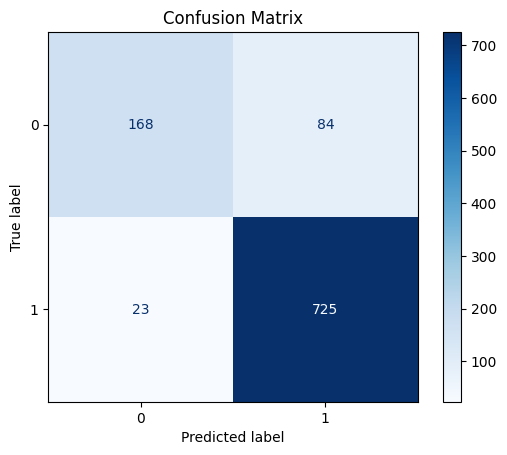

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict all test samples
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(yb.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot it
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
